In [15]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

torch.__version__
torchtext.__version__

cpu


'0.16.2+cpu'

In [16]:
from indicnlp.tokenize import sentence_tokenize, indic_tokenize
from datasets import load_dataset, DatasetDict
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


In [ ]:
# 1. Data Loading
# Load the full dataset
dataset = load_dataset("opus100", "en-si")
print("Original size of dataset: ", dataset)

# Reduce the training set to 10,000 samples
# Otherwise I can't finish and submit this assientment!!!
# I try to maintain the ratio of 0.2 (traning set and test set)
small_train_dataset = dataset["train"].select(range(10000))
small_test_dataset = dataset["test"].select(range(2000))
small_validation_dataset = dataset["validation"].select(range(2000))

dataset = DatasetDict({
    "train": small_train_dataset,
    "test": small_test_dataset,
    "validation": small_validation_dataset
})

# Verify the new sizes
print(dataset)

Original size of dataset:  DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 979109
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})
DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


In [18]:
# 2. Preprocessing: Tokenization and Numericalization
SRC_LANGUAGE = "en"
TRG_LANGUAGE = "si"

token_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

def sinhala_tokenizer(text):
    return indic_tokenize.trivial_tokenize(text, lang='si')

token_transform[TRG_LANGUAGE] = sinhala_tokenizer

# Function to yield tokenized sentences from training data
def yield_tokens(data, language):
    for data_sample in data:
        yield token_transform[language](data_sample["translation"][language])

# Define special tokens
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

# Build vocabulary from training set
vocab_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(dataset["train"], ln),
        min_freq=2,
        specials=special_symbols,
        special_first=True
    )

# Set default index for unknown words
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

sample_si = dataset["train"][10]["translation"]["si"]
print("Raw Sinhala:", sample_si)
print("Tokenized:", sinhala_tokenizer(sample_si))

# Save vocabulary to files (ADDED THIS SECTION)
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    torch.save(vocab_transform[ln], f'vocab_{ln}.pt')
    print(f"Saved {ln} vocabulary to 'vocab_{ln}.pt'")


# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    
    for item in batch:
        src_sample = item["translation"][SRC_LANGUAGE]  # Extract English sentence
        trg_sample = item["translation"][TRG_LANGUAGE]  # Extract Sinhala sentence

        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)

    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch



# Create data loaders
BATCH_SIZE = 8
train_loader = torch.utils.data.DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = torch.utils.data.DataLoader(dataset["validation"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = torch.utils.data.DataLoader(dataset["test"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
train_loader_length = len(train_loader)

Raw Sinhala: මොනවහරි ඕනද ඔයාට ?
Tokenized: ['මොනවහරි', 'ඕනද', 'ඔයාට', '?']
Saved en vocabulary to 'vocab_en.pt'
Saved si vocabulary to 'vocab_si.pt'


In [19]:
 len(train_loader)

1250

In [20]:
for en, en_len, si in train_loader:
    print("English shape: ", en.shape)  # (batch_size, seq_len)
    print("Sinhala shape: ", si.shape)  # (batch_size, seq_len)
    break  # Print for the first batch only

English shape:  torch.Size([8, 11])
Sinhala shape:  torch.Size([8, 12])


In [21]:
# Add this after loading data
max_src_len = max(len(x["translation"][SRC_LANGUAGE]) for x in dataset["train"])
max_trg_len = max(len(x["translation"][TRG_LANGUAGE]) for x in dataset["train"])
max_length = max(max_src_len, max_trg_len) + 10  # Add buffer

In [22]:
# Design the model
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

#Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 200):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
 
# multihead attention
    
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
 
# PositionwiseFeedforwardLayer    
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x   
  
#decoder
    
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention
    
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device,max_length = 200):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention
   
    
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

# Traning    
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
        

input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 2
dec_layers = 2
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              device, max_length=max_length)

dec = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              dec_dropout, 
              device, max_length=max_length)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(3179, 256)
    (pos_embedding): Embedding(329, 256)
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
   

In [23]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

813824
 84224
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1015296
 84224
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1015296
  3966
______
5652606


In [24]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [ ]:


def train(model, loader, optimizer, criterion, clip, loader_length):
    model.train()
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output, _ = model(src, trg[:, :-1])
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        
        # Compute loss
        loss = criterion(output, trg)
        
        # Check for NaN or Inf in loss
        if math.isnan(loss.item()) or math.isinf(loss.item()):
            print("NaN or Inf detected in loss. Skipping this batch.")
            continue
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / loader_length

def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

#save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model-multi-Head-attention.pt') #save_path)
    
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 39s
	Train Loss: 4.630 | Train PPL: 102.542
	 Val. Loss: 4.185 |  Val. PPL:  65.700
Epoch: 02 | Time: 1m 48s
	Train Loss: 4.132 | Train PPL:  62.281
	 Val. Loss: 4.097 |  Val. PPL:  60.182
Epoch: 03 | Time: 1m 49s
	Train Loss: 3.871 | Train PPL:  48.005
	 Val. Loss: 4.018 |  Val. PPL:  55.605
Epoch: 04 | Time: 1m 49s
	Train Loss: 3.648 | Train PPL:  38.399
	 Val. Loss: 4.001 |  Val. PPL:  54.654
Epoch: 05 | Time: 1m 49s
	Train Loss: 3.430 | Train PPL:  30.885
	 Val. Loss: 4.003 |  Val. PPL:  54.775
Epoch: 06 | Time: 1m 49s
	Train Loss: 3.223 | Train PPL:  25.095
	 Val. Loss: 4.038 |  Val. PPL:  56.688
Epoch: 07 | Time: 1m 50s
	Train Loss: 3.026 | Train PPL:  20.612
	 Val. Loss: 4.086 |  Val. PPL:  59.496


Text(0, 0.5, 'loss')

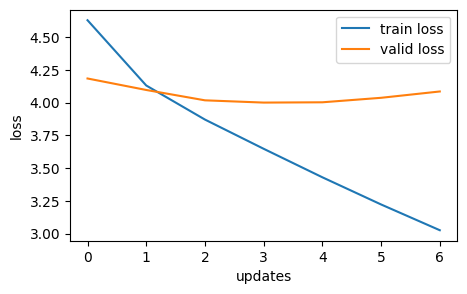

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [ ]:
model.load_state_dict(torch.load('best-model-multi-Head-attention.pt'))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.007 | Test PPL:  54.968 |


C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_12672\1889594676.py:63: UserWarning: Glyph 3512 (\N{SINHALA LETTER MAYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_12672\1889594676.py:63: UserWarning: Matplotlib currently does not support Sinhala natively.
  plt.tight_layout()
C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_12672\1889594676.py:63: UserWarning: Glyph 3484 (\N{SINHALA LETTER ALPAPRAANA GAYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_12672\1889594676.py:63: UserWarning: Glyph 3546 (\N{SINHALA VOWEL SIGN DIGA KOMBUVA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_12672\1889594676.py:63: UserWarning: Glyph 3520 (\N{SINHALA LETTER VAYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_12672\18

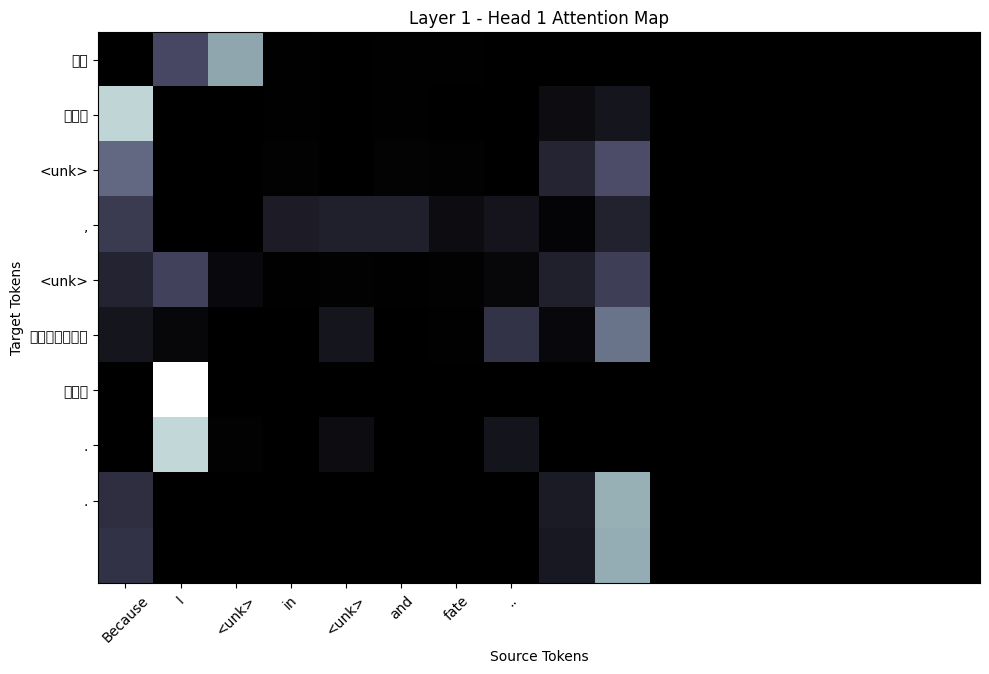

In [48]:
import matplotlib.pyplot as plt

# Function to get attention weights for Layer 1, Head 1
def get_attention_layer1_head1(model, src, trg):
    # List to store attention weights
    attentions = []
    
    # Register hook to capture attention weights from Layer 1, Head 1
    def hook(module, input, output):
        # output[1] contains the attention weights
        attentions.append(output[1].detach())
    
    # Attach hook to the first decoder layer's attention
    hook_handle = model.decoder.layers[0].encoder_attention.register_forward_hook(hook)
    
    # Forward pass to trigger the hook
    with torch.no_grad():
        model(src, trg)
    
    # Remove the hook
    hook_handle.remove()
    
    # Extract attention weights for Layer 1, Head 1
    # Shape: [batch_size, num_heads, trg_len, src_len]
    attention_layer1_head1 = attentions[0][0, 0]  # First layer, first head
    return attention_layer1_head1

# Function to visualize attention for Layer 1, Head 1
def visualize_attention_layer1_head1(model, data_loader, vocab_transform, src_lang, trg_lang, index=0):
    # Get a sample from the test set
    src, _, trg = next(iter(data_loader))
    src, trg = src[index:index+1].to(device), trg[index:index+1].to(device)
    
    # Get attention weights for Layer 1, Head 1
    attention = get_attention_layer1_head1(model, src, trg[:, :-1])  # Exclude <eos>
    
    # Convert token IDs to words
    src_tokens = [vocab_transform[src_lang].get_itos()[i] for i in src[0].cpu().numpy()]
    trg_tokens = [vocab_transform[trg_lang].get_itos()[i] for i in trg[0].cpu().numpy()]
    
    # Clean special tokens
    src_tokens_clean = [tok for tok in src_tokens if tok not in ['<sos>', '<eos>', '<pad>']]
    trg_tokens_clean = [tok for tok in trg_tokens if tok not in ['<sos>', '<eos>', '<pad>']]
    
    # Plot the attention map
    plt.figure(figsize=(10, 8))
    plt.imshow(attention.cpu().numpy(), cmap='bone')
    plt.xlabel("Source Tokens")
    plt.ylabel("Target Tokens")
    plt.title("Layer 1 - Head 1 Attention Map")
    
    # Set x and y ticks
    plt.xticks(
        range(len(src_tokens_clean)),
        labels=src_tokens_clean,
        rotation=45
    )
    plt.yticks(
        range(len(trg_tokens_clean)),
        labels=trg_tokens_clean
    )
    
    plt.tight_layout()
    plt.show()

# Visualize attention for the first sample in the test set
visualize_attention_layer1_head1(model, test_loader, vocab_transform, SRC_LANGUAGE, TRG_LANGUAGE, index=0)

In [ ]:
import torch

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('best-model-multi-Head-attention.pt', map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode

def translate_sentence(model, sentence, text_transform, SRC_LANGUAGE, TRG_LANGUAGE, vocab_transform, device, max_length=50):
    model.eval()
    
    # Preprocess input sentence
    src_tensor = text_transform[SRC_LANGUAGE](sentence).unsqueeze(0).to(device)  # Shape: [1, seq_len]
    
    # Create a tensor for the generated output, starting with <sos>
    trg_indexes = [SOS_IDX]
    
    with torch.no_grad():
        for _ in range(max_length):
            trg_tensor = torch.tensor(trg_indexes).unsqueeze(0).to(device)  # Shape: [1, current_seq_len]
            
            # Forward pass through the model (only src and trg)
            output, _ = model(src_tensor, trg_tensor)
            
            # Get the predicted token (last token in sequence)
            pred_token = output.argmax(2)[:, -1].item()
            
            # Append to the output sequence
            trg_indexes.append(pred_token)
            
            # Stop if <eos> token is generated
            if pred_token == EOS_IDX:
                break

    # Convert token indexes to words
    trg_tokens = [vocab_transform[TRG_LANGUAGE].get_itos()[idx] for idx in trg_indexes[1:]]  # Skip <sos>
    return " ".join(trg_tokens)

# Example Usage:
sentence = "Hello, how are you?"  # Replace with any English sentence
translation = translate_sentence(model, sentence, text_transform, SRC_LANGUAGE, TRG_LANGUAGE, vocab_transform, device)
print(f"Translated Sentence: {translation}")

Translated Sentence: ඔයා කොහොමද ? <eos>


In [ ]:
# Test for accuracy with BLEU score
import torch
from sacrebleu import corpus_bleu

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('best-model-multi-Head-attention.pt', map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode

def translate_sentence(model, sentence, text_transform, SRC_LANGUAGE, TRG_LANGUAGE, vocab_transform, device, max_length=50):
    model.eval()
    
    # Preprocess input sentence
    src_tensor = text_transform[SRC_LANGUAGE](sentence).unsqueeze(0).to(device)  # Shape: [1, seq_len]
    
    # Create a tensor for the generated output, starting with <sos>
    trg_indexes = [SOS_IDX]
    
    with torch.no_grad():
        for _ in range(max_length):
            trg_tensor = torch.tensor(trg_indexes).unsqueeze(0).to(device)  # Shape: [1, current_seq_len]
            
            # Forward pass through the model (only src and trg)
            output, _ = model(src_tensor, trg_tensor)
            
            # Get the predicted token (last token in sequence)
            pred_token = output.argmax(2)[:, -1].item()
            
            # Stop if <eos> token is generated
            if pred_token == EOS_IDX:
                break  # Break before appending <eos>
            
            # Append to the output sequence
            trg_indexes.append(pred_token)
    
    # Convert token indexes to words
    trg_tokens = [vocab_transform[TRG_LANGUAGE].get_itos()[idx] for idx in trg_indexes[1:]]  # Skip <sos>
    return " ".join(trg_tokens)

def compute_bleu(reference_texts, predicted_texts):
    # Compute BLEU score using sacrebleu
    return corpus_bleu(predicted_texts, [reference_texts]).score

# Load Test Data (Example)
test_sentences = [
    "I can do it .",
    "I do not like you ."  # Updated sentence
]

# Reference Translations (Ground Truth Sinhala)
reference_translations = [
    "මට එය කළ හැකිය .",  # Translation for "I can do it ."
    "මම ඔයාට කැමති නෑ ."  # Translation for "I do not like you ."
]

# Generate Model Translations
predicted_translations = [
    translate_sentence(model, sentence, text_transform, SRC_LANGUAGE, TRG_LANGUAGE, vocab_transform, device)
    for sentence in test_sentences
]

# Compute BLEU Score
bleu_score = compute_bleu(reference_translations, predicted_translations)

# Print Results
for i, (src, pred, ref) in enumerate(zip(test_sentences, predicted_translations, reference_translations)):
    print(f"\n🔹 Sentence {i+1}")
    print(f"  🔹 English  : {src}")
    print(f"  🔹 Predicted Sinhala : {pred}")
    print(f"  🔹 Reference Sinhala : {ref}")

print(f"\n BLEU Score: {bleu_score:.2f}")